In [2]:
# pca_single_time_reduced.ipynb
# Noah Stiegler
# 7/2/24
# Exploring how the PCA works for just a single time of a single source
# And with snr, power, incoherent power all lumped together

### Setup

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from astropy import units as u
from astropy.coordinates import Angle
from astropy.table import Table
from astropy.time import Time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'sklearn'

In [3]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1":
    full_dataset_path = "/datax/scratch/nstieg/25GHz_higher.pkl"
    coherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_coherent.pkl"
    incoherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_incoherent.pkl"
else:
    raise Exception("Data path not known")

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

3127348761205770496
60212.56062466325
(1800, 3)


<Axes: xlabel='signal_frequency', ylabel='signal_drift_rate'>

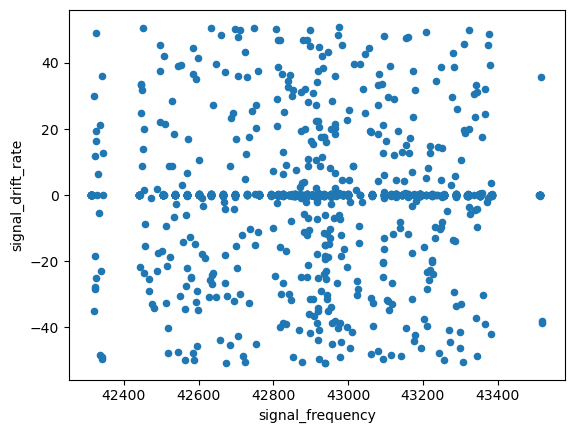

In [4]:
# Keep columns I think might be important
columns_we_care_about = [
    "signal_frequency",
    "signal_drift_rate",
	"signal_power"]

# Take only data from a single source
first_source = coherent["source_name"][0]
print(first_source)
indices_of_first_source = coherent["source_name"] == first_source
first_time = coherent["tstart"][0]
print(first_time)
indices_of_first_time = coherent["tstart"] == first_time
indices_of_data = indices_of_first_source & indices_of_first_time
data = coherent[indices_of_data][columns_we_care_about]
print(data.shape)

data.plot.scatter("signal_frequency", "signal_drift_rate")

### Look at original data

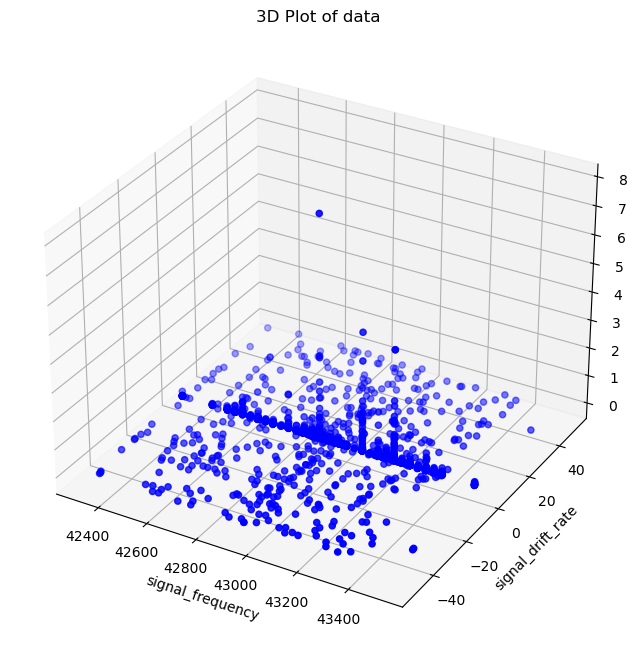

In [5]:
# Do a 3d plot with all 3 features
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points as a 3D scatter plot
features = [data[column] for column in data.columns]
ax.scatter(features[0], features[1], features[2], c='blue', marker='o')

# Set labels and title
ax.set_xlabel(data.columns[0])
ax.set_ylabel(data.columns[1])
ax.set_zlabel(data.columns[2])
ax.set_title('3D Plot of data')

# Show plot
plt.show()

### Run PCA

In [6]:
# Normalize (standardize) the data to have mean 0 and std dev of 1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
print(scaled_data.shape)

(1800, 3)


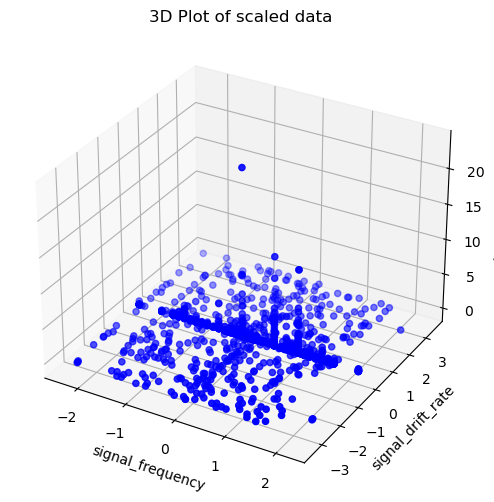

In [30]:
# Do a 3d plot with all 3 scaled features
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points as a 3D scatter plot
ax.scatter(scaled_data[:, 0], scaled_data[:, 1], scaled_data[:, 2], c='blue', marker='o')

# Set labels and title
ax.set_xlabel(data.columns[0])
ax.set_ylabel(data.columns[1])
ax.set_zlabel(data.columns[2])
ax.set_title('3D Plot of scaled data')

# Show plot
plt.show()

In [7]:
# Create PCA object
pca = PCA()

# Fit PCA to the data
pca.fit(scaled_data)

PCA()

In [8]:
# Get the coordinates of the original data in the transformed space
principal_components = pca.transform(scaled_data)  # Use scaled_data if standardized, df if not standardized
print(principal_components.shape)

(1800, 3)


In [9]:
# See how much of the variance in the data is explained by
# each principal component
explained_variance = pca.explained_variance_ratio_

### Look at the principal component vectors

In [10]:
# See what the components of the PCAs are
components = pca.components_
columns = data.columns
precision = 4
for i, component in enumerate(components):
    to_print = f"PC{i} = {round(component[0], precision)}x({columns[0]})"
    for j in range(1, len(columns)):
        to_print += f" + {round(component[j], precision)}x({columns[j]})"

    print(to_print)

PC0 = 0.6938x(signal_frequency) + 0.2057x(signal_drift_rate) + 0.6902x(signal_power)
PC1 = 0.1267x(signal_frequency) + -0.9783x(signal_drift_rate) + 0.1641x(signal_power)
PC2 = -0.7089x(signal_frequency) + 0.0264x(signal_drift_rate) + 0.7048x(signal_power)


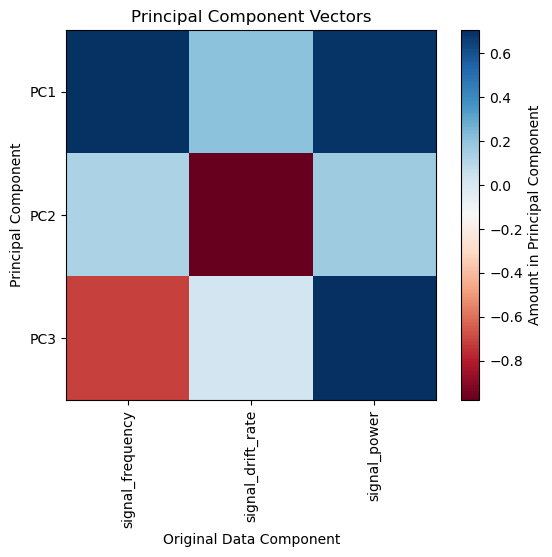

In [11]:
# Show the principal component vectors visually
plt.imshow(components, cmap='RdBu')
plt.title("Principal Component Vectors")
plt.xlabel("Original Data Component")
plt.ylabel("Principal Component")

# Colorbar
cbar = plt.colorbar(label="Amount in Principal Component")

# Change ticks
num_components = len(components)
tick_nums = np.arange(num_components)
plt.gca().set_xticks(tick_nums)
plt.gca().set_yticks(tick_nums)
PC_labels = [f"PC{i}" for i in range(1, num_components + 1)]
plt.gca().set_xticklabels(columns, rotation='vertical')
plt.gca().set_yticklabels(PC_labels)

plt.show()

### Look at explained variance

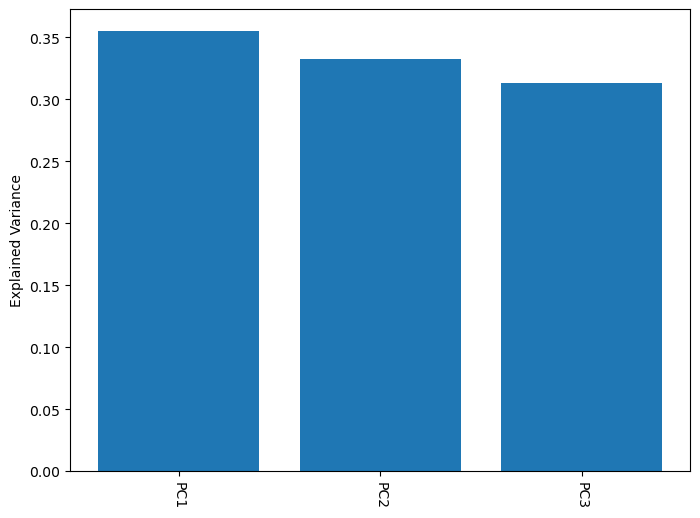

In [12]:
# Plot explained variance
fig, ax = plt.subplots(figsize=(8, 6))
xlabels = [f"PC{i}" for i in range(1, len(explained_variance) + 1)]
ax.bar(xlabels, explained_variance)
plt.xticks(rotation=-90) 
plt.ylabel("Explained Variance")
plt.show()

Text(0, 0.5, 'Variance Explained by Components')

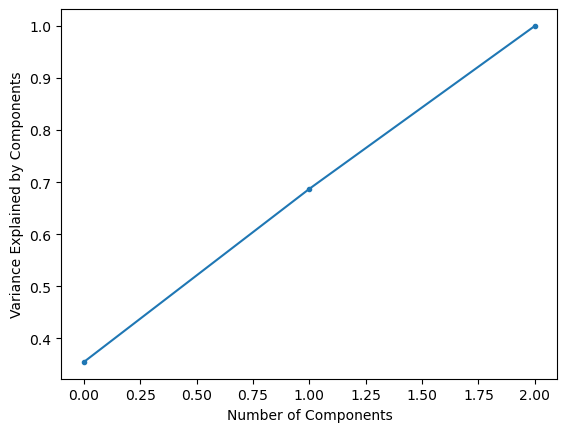

In [13]:
# Plot cumulative variance with number of columns
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(len(data.columns)), cumulative_variance, marker='.')
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained by Components")

### Look at biplots

In [14]:
# A function to plot the data on the first two principal component
# axes and color the points by one of the original features
def plot_first_2_pcs(color_feature=None):
    if color_feature != None:
        plt.scatter(principal_components[:, 0], principal_components[:, 1], marker=".", c=data[color_feature])
        plt.colorbar(label=color_feature)
    else:
        plt.scatter(principal_components[:, 0], principal_components[:, 1], marker=".")

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("First 2 PCs")
    plt.show()

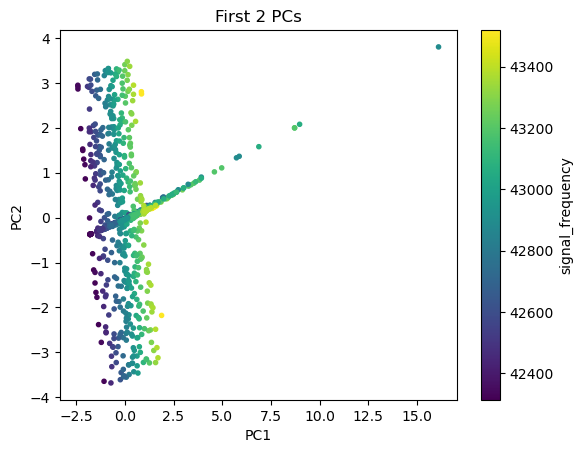

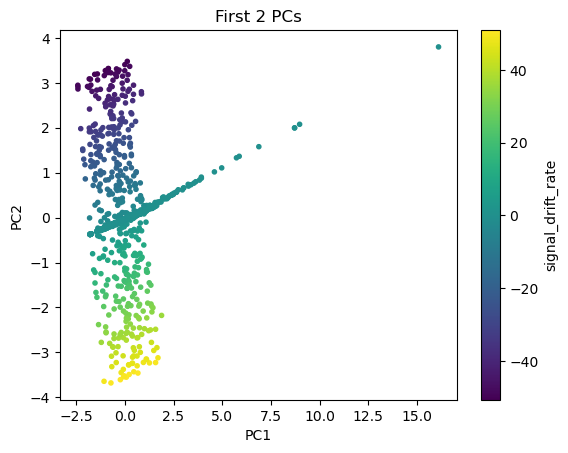

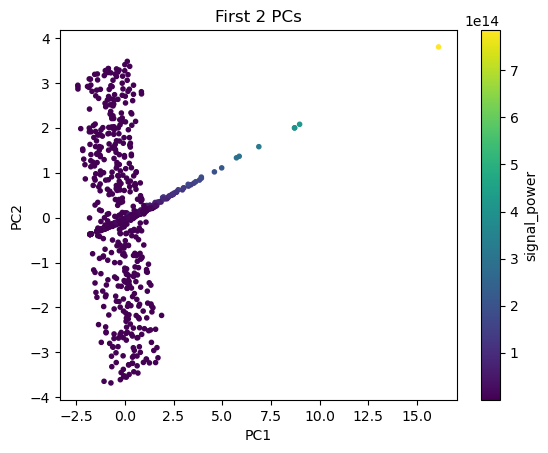

In [15]:
# Look at how the original features are distributed on the plot
for column in columns:
    plot_first_2_pcs(color_feature=column)

### Visualize all 3 PCs

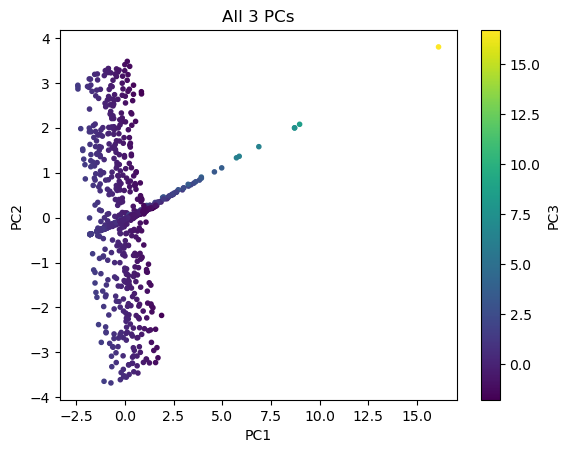

In [16]:
# Color the plot by the third principal component
plt.scatter(principal_components[:, 0], principal_components[:, 1], marker=".", c=principal_components[:, 2])
plt.colorbar(label="PC3")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("All 3 PCs")
plt.show()

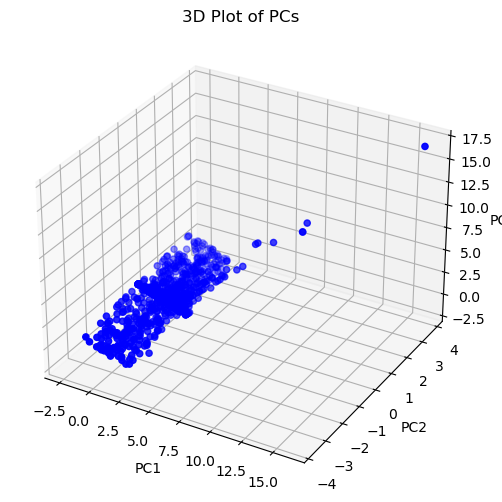

In [17]:
# Do a 3d plot with all 3 principal components
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points as a 3D scatter plot
PC = [principal_components[:, i] for i in range(principal_components.shape[1])]
ax.scatter(PC[0], PC[1], PC[2], c='blue', marker='o')

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Plot of PCs')

# Show plot
plt.show()

### Look a the directions of the features in PC space

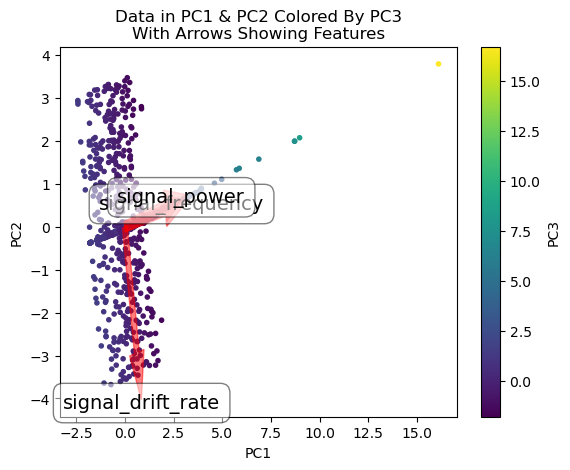

In [18]:
# Show the directions of the original features on the biplot
plt.scatter(principal_components[:, 0], principal_components[:, 1], marker=".", c=principal_components[:, 2])
plt.colorbar(label="PC3")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Data in PC1 & PC2 Colored By PC3\nWith Arrows Showing Features")

feature_directions = components.T # Each row is a feature (frequency, drift rate, etc) and column is its pc1, 2, 3 coordinate
for i, feature in enumerate(data.columns):
    arrow_length_scale = 3
    plt.arrow(0, 0, feature_directions[i, 0] * arrow_length_scale, feature_directions[i, 1] * arrow_length_scale, 
              color='r', alpha=0.5, width=.25)
    text_length_scale = arrow_length_scale * 1.4
    plt.text(feature_directions[i, 0] * text_length_scale, feature_directions[i, 1] * text_length_scale, feature, 
             color='black', ha='center', va='center', size=14, 
             bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.show()

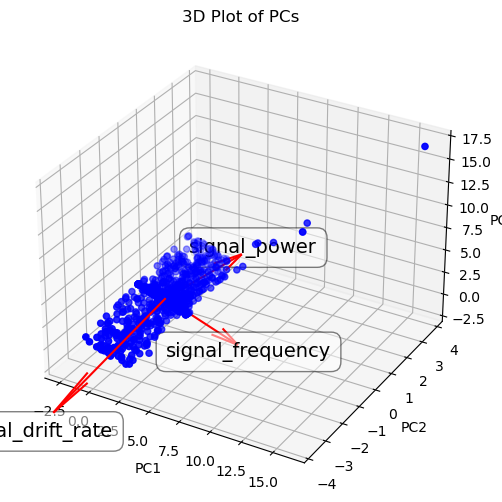

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=30, azim=45)  # Change elevation (vertical angle) and azimuth (horizontal angle)

# Plot data points as a 3D scatter plot
PC = [principal_components[:, i] for i in range(principal_components.shape[1])]
ax.scatter(PC[0], PC[1], PC[2], c='blue', marker='o')

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Plot of PCs')

feature_directions = components.T # Each row is a feature (frequency, drift rate, etc) and column is its pc1, 2, 3 coordinate
arrow_len_multiplier = 7
for i, feature in enumerate(data.columns):
    arrow_length = np.sqrt(np.sum(feature_directions[i]**2))
    ax.quiver(0, 0, 0,
              feature_directions[i, 0], feature_directions[i, 1], feature_directions[i, 2],
              length=arrow_length * arrow_len_multiplier, normalize=True, color='red')
    text_length_scale = arrow_length * arrow_len_multiplier * 1.15
    ax.text(feature_directions[i, 0] * text_length_scale, feature_directions[i, 1] * text_length_scale, feature_directions[i, 2] * text_length_scale, feature, 
             color='black', ha='center', va='center', size=14, 
             bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))
    
# Show plot
plt.show()

### Make gif of data in PC space with feature arrows

In [1]:
# Import packages for interacting with filesystem and making gifs
import imageio
import os
import glob

# Plot a single frame at a given angle
def plot_with_angle(elev, azim):
    # Setup figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)  # Change elevation (vertical angle) and azimuth (horizontal angle)

    # Plot data points as a 3D scatter plot
    PC = [principal_components[:, i] for i in range(principal_components.shape[1])]
    ax.scatter(PC[0], PC[1], PC[2], c='blue', marker='o')

    # Set labels and title
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D Plot of PCs')

    # Plot feature arrows
    feature_directions = components.T # Each row is a feature (frequency, drift rate, etc) and column is its pc1, 2, 3 coordinate
    arrow_len_multiplier = 7
    for i, feature in enumerate(data.columns):
        arrow_length = np.sqrt(np.sum(feature_directions[i]**2))
        ax.quiver(0, 0, 0,
                feature_directions[i, 0], feature_directions[i, 1], feature_directions[i, 2],
                length=arrow_length * arrow_len_multiplier, normalize=True, color='red')
        text_length_scale = arrow_length * arrow_len_multiplier * 1.15
        ax.text(feature_directions[i, 0] * text_length_scale, feature_directions[i, 1] * text_length_scale, feature_directions[i, 2] * text_length_scale, feature, 
                color='black', ha='center', va='center', size=14, 
                bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

    # Save plot
    filename = f'{path}/frame_{elev}_{azim}.png'
    if os.path.exists(filename):
        os.remove(filename)
    plt.savefig(filename)
    plt.close(fig)
    
# Create a directory to store frames
path = "/home/nstieg/BL-COSMIC-2024-proj/pca_exploration/3d_scatter_frames"
if not os.path.exists(path):
    os.makedirs(path)

# Generate frames
angles = range(0, 360, 5)  # Angles from 0 to 355 (360 degrees in steps of 5)
for i, angle in enumerate(angles):
    plot_with_angle(20, angle)

# Create a list of frames
frames = []
for i, angle in enumerate(angles):
    filename = f'{path}/frame_{20}_{angle}.png'
    frames.append(imageio.imread(filename))

# Save frames as a GIF
gif_path = f'{path}/3d_scatter_rotation.gif'
if os.path.exists(gif_path):
    os.remove(gif_path)
imageio.mimsave(gif_path, frames, duration=0.1, loop=0)
print(f'Animated GIF saved: {gif_path}')

# Delete the pngs so they don't clutter things up
pattern = os.path.join(path, '*.png')
png_files = glob.glob(pattern)
for file in png_files:
    try:
        os.remove(file)
    except OSError as e:
        print(f"Error deleting {file}: {e}")
print("Cleaned up the remaining .pngs")

NameError: name 'plt' is not defined